In [3]:
library(tidyverse)

-- Attaching packages ------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ---------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [4]:
df <- read.csv('./hw2/training.csv', sep = ',')
head(df)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,...,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,...,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,...,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,...,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,...,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,Research & Development,2,2,Life Sciences,8,4,Male,...,3,3,0,8,2,2,7,7,3,6


In [5]:
colnames(df)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "NumCompaniesWorked"       "PerformanceRating"       
[19] "RelationshipSatisfaction" "StockOptionLevel"        
[21] "TotalWorkingYears"        "TrainingTimesLastYear"   
[23] "WorkLifeBalance"          "YearsAtCompany"          
[25] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[27] "YearsWithCurrManager"

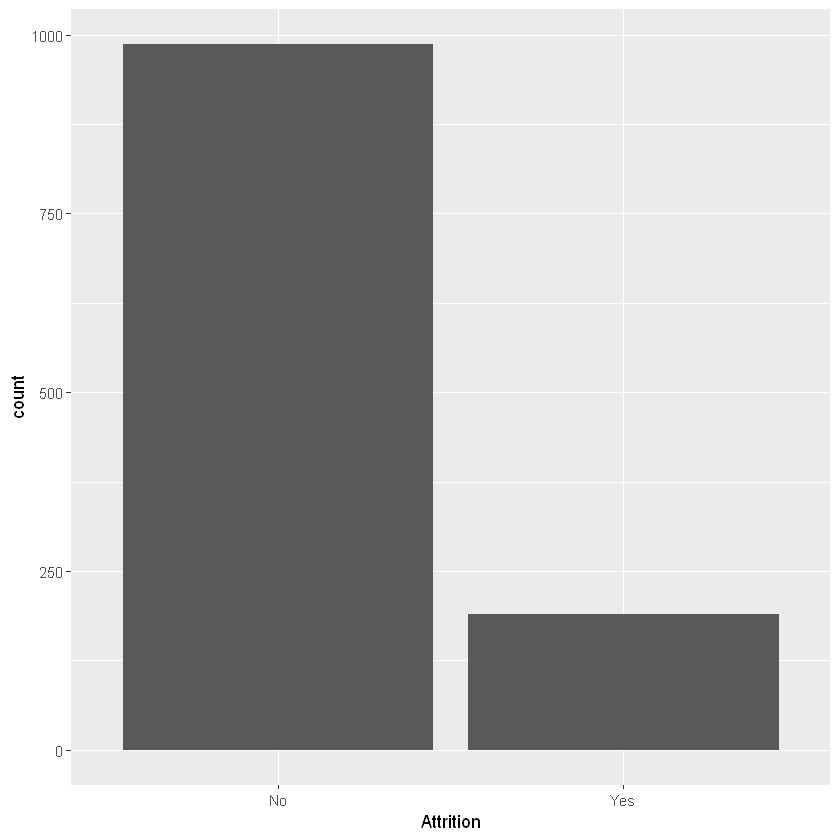

In [6]:
ggplot(df, aes(x = Attrition)) + geom_bar()

In [7]:
set_col_to_factor <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.factor(df[, col])
  }
  return(df)
}
set_col_to_integer <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols) {
    df[, col] <- as.integer(df[, col])
  }
  return(df)
}
set_col_to_numeric <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.numeric(df[, col])
  } 
  return (df)
}

In [8]:
df <- set_col_to_factor(df, 'Attrition', 'Gender', 'Department')
df <- set_col_to_integer(df, 'Age')

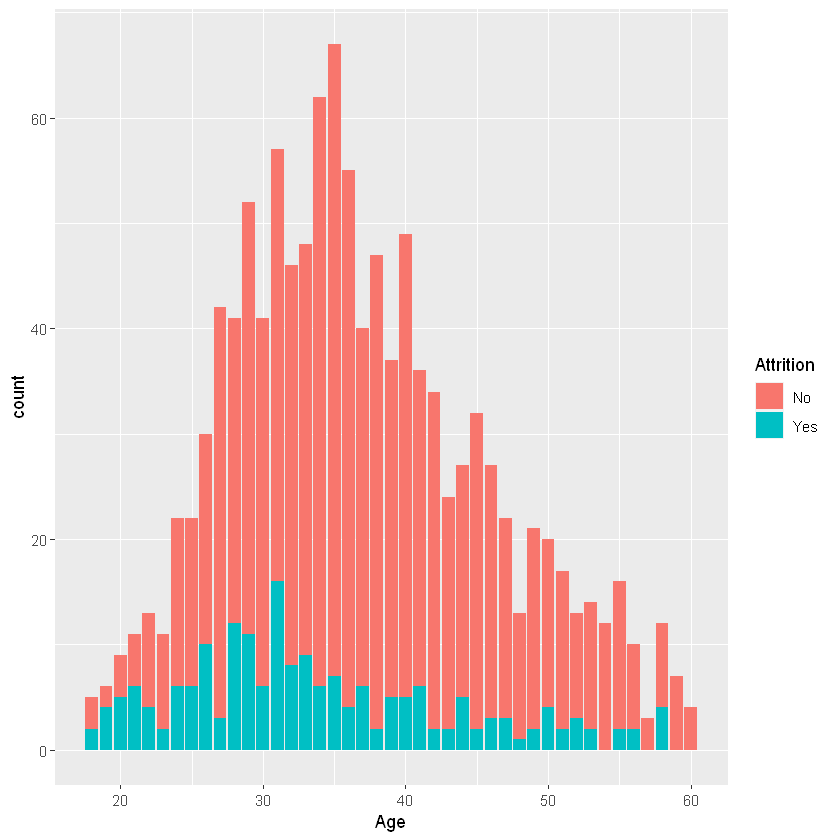

In [9]:
ggplot(df, aes(x = Age, fill = Attrition)) + geom_bar()

In [10]:
build_fold_indices <- function(fold) {
  test_fold <- 1:fold
  shifted <- (test_fold + 1)
  valid_fold <- ifelse((shifted > fold), shifted %% fold, shifted)
  fold_indices <- data.frame(test = test_fold, valid = valid_fold)
  
  return(fold_indices)
}

pick_out_indices <- function(total_rows, fold, ...) {
  indices <- c()
  
  for (i in list(...)) {
    indices <- append(indices, seq(i, total_rows, fold))
  }
  
  indices <- unique(indices)
  
  return(indices)
}

get_by_exclude <- function(df, fold, ...) {
  total_rows <- nrow(df)
  exclude <- pick_out_indices(total_rows, fold, ...)
  excluded <- df[-exclude,]
  
  return(excluded)
}

get_by_index <- function(df, fold, ...) {
  total_rows <- nrow(df)
  
  include <- pick_out_indices(total_rows, fold, ...)
  included <- df[include,]
  
  return(included)
}

subset_by_fold <- function(df, fold, index, indices){
  training_frame <- get_by_exclude(df,
                                   fold,
                                   indices[index, ]$test,
                                   indices[index, ]$valid)
  validation_frame <- get_by_index(df, fold, indices[index, ]$valid)
  testing_frame <- get_by_index(df, fold, indices[index, ]$test)
  
  return(list(training=training_frame,
              validation=validation_frame,
              testing=testing_frame))
}

In [11]:
fold <- 3
index <- 1
fold_indices <- build_fold_indices(fold)
splitted_frames <- subset_by_fold(df, fold, index, fold_indices)

In [12]:
library(rpart)

train_dt <- function(df, depth) {
  model <- rpart(
    Attrition ~ .,
    data = df,
    control = rpart.control(maxdepth = depth),
    method = "class"
  )
  return (model)
}

predict_dt <- function(model, df) {
  pred_frame <- predict(model, df, type = "class")
  return (pred_frame)
}

In [21]:
build_cm <- function(df, pred) {
  result_frame <- data.frame(truth = df$Attrition,
                             pred = pred)
  result_table <- table(result_frame)
  return(result_table)
}

cal_pred_result <- function(cM) {
  true_col <- 2
  false_col <- 1
  positive_row <- 2
  negative_row <- 1
  
  TP <- cM[positive_row, ][true_col]
  FN <- cM[positive_row, ][false_col]
  TN <- cM[negative_row, ][false_col]
  FP <- cM[negative_row, ][true_col]
  
  result <- c(TP, FP, TN, FN)
  names(result) = c("TP", "FP", "TN", "FN")
  return(result)
}

get_rounded <- function(value, round_digits = 2) {
  return(round(value, digits = round_digits))
}

cal_accu <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  total_rows = TP + FN + TN + FP
  accuracy <- (TP + TN) / total_rows
  return(get_rounded(accuracy))
}

cal_sensitivity <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  sensitivity <- TP / (TP + FN)
  return(get_rounded(sensitivity))
}

cal_specificity <- function(pred_result) {
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  specificity <- TN / (TN + FP)
  return(get_rounded(specificity))
}

cal_F1 <- function(pred_result) {
  precision <- cal_precision(pred_result)
  recall <- cal_sensitivity(pred_result)
  F1 <- (2 * precision * recall) / (precision + recall)
  return(get_rounded(F1))
}

cal_precision <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FP <- unname(pred_result["FP"])
  precision <- TP / (TP + FP)
  return(get_rounded(precision))
}

evaluate_model <- function(df, pred){
  predict_cm <- build_cm(df, pred)
  predict_result <- cal_pred_result(predict_cm)
  accu <- cal_accu(predict_result)
  preci <- cal_precision(predict_result)
  sens <- cal_sensitivity(predict_result)
  recl <- sens
  spec <- cal_specificity(predict_result)
  f1 <- cal_F1(predict_result)
  
  return(list(accuracy=accu,
              recall=recl,
             precision=preci,
             sensitivity=sens,
             specificity=spec,
             F1=f1))
}

In [22]:
model <- train_dt(splitted_frames$training, 5)

pred_train <- predict_dt(model, splitted_frames$training)
result_train <- evaluate_model(splitted_frames$training, pred_train)
pred_valid <- predict_dt(model, splitted_frames$validation)
result_valid <- evaluate_model(splitted_frames$validation, pred_valid)
pred_test <- predict_dt(model, splitted_frames$testing)
result_test <- evaluate_model(splitted_frames$testing, pred_test)

In [23]:
print('train result:')
print(result_train)

[1] "train result:"
$accuracy
[1] 0.89

$recall
[1] 0.35

$precision
[1] 0.81

$sensitivity
[1] 0.35

$specificity
[1] 0.98

$F1
[1] 0.49



In [24]:
print('validation:')
print(result_valid)

[1] "validation:"
$accuracy
[1] 0.83

$recall
[1] 0.16

$precision
[1] 0.33

$sensitivity
[1] 0.16

$specificity
[1] 0.95

$F1
[1] 0.22



In [25]:
print('testing')
print(result_test)

[1] "testing"
$accuracy
[1] 0.82

$recall
[1] 0.17

$precision
[1] 0.48

$sensitivity
[1] 0.17

$specificity
[1] 0.96

$F1
[1] 0.25

